In [14]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from pyqg_generative.tools.plot_helpers import *
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def open_zarr(folder, url='https://g-402b19.00888.8540.data.globus.org'):
    mapper = fsspec.get_mapper(f'{url}/{folder}.zarr')
    return xr.open_zarr(mapper, consolidated=True)

In [3]:
import json
def read_model(folder):
  with open(f'{folder}/model_args.json') as file:
    model_args = json.load(file)
    return eval(model_args.pop('model'))(folder=folder, **model_args)

# Read training data

In [61]:
ds=open_zarr('eddy/96/gauss', url='/scratch/pp2681/generative-zarr')

In [62]:
sel = lambda x: x.isel(time=slice(-1,None),run=slice(4,5))

# Read GAN model

In [63]:
from pyqg_generative.models.cgan_regression import CGANRegression
gan = read_model('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-96/CGANRegression-retrain-0/model')

reading CGANRegression G, D from /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models_retrain/Operator2-96/CGANRegression-retrain-0/model


# Predict 100 realizations of subgrid forcing

In [64]:
default_rcParams({
        'font.size': 16,
        'axes.labelsize': 16,
        'axes.titlesize': 18,
        'xtick.labelsize': 10,
        'ytick.labelsize': 13,
        'legend.fontsize': 10})

In [65]:
import pyqg
m = pyqg.QGModel(nx=96)
m.q = sel(ds.q).squeeze().values.astype('float64')

INFO:  Logger initialized


In [66]:
def plot_qS(m, z, lev=1, vmax=1.1e-13, cmap='bwr'):
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    imshow(m.q[lev], cbar_label='Potential vorticity, $s^{-1}$')
    plt.title('Resolved PV, $\overline{q}$')
    plt.subplot(1,2,2)
    S = gan.predict_snapshot(m, z)
    imshow(S[lev], cbar_label='PV subgrid forcing, $s^{-2}$', cmap=cmap, vmax=vmax)
    plt.title('Sample of subgrid forcing, \n $S \\sim \\rho(S|\overline{q})$')

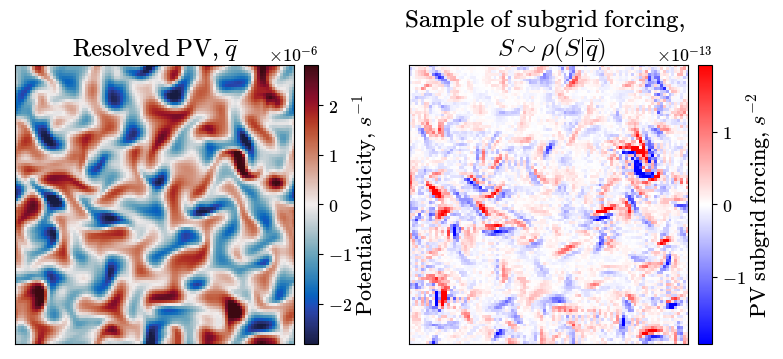

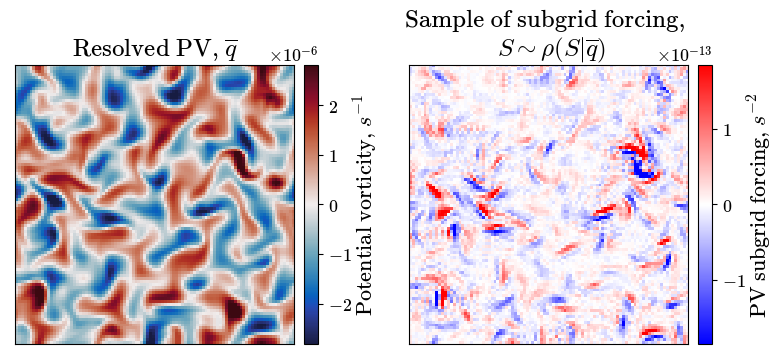

In [67]:
plot_qS(m, z=gan.generate_latent_noise(m.nx,m.nx), vmax=None)
plot_qS(m, z=gan.generate_latent_noise(m.nx,m.nx), vmax=None)

# Generate correlated latent noise for GIF

In [68]:
from pyqg_generative.tools.stochastic_pyqg import AR1_sampler
def save_fig(nsteps=10, nframes=30, filename='my-animation.gif'):
    noise_generator = lambda : gan.generate_latent_noise(96,96)
    sampler = AR1_sampler(nsteps)
    noise = []
    for i in range(nframes):
        if sampler.update(noise_generator):
            noise.append(sampler.noise)
    fun = lambda j: plot_qS(m, noise[j], cmap=None)#, vmax=1.44e-13)
    create_animation(fun, range(nframes), filename=filename)

In [69]:
save_fig(nsteps=5, nframes=50, filename='eddy.gif')

Animation at FPS=24 will last for 2.0833333333333335 seconds
